## 0. Computer vision libraries in PyTorch

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


## 1. Getting a dataset

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [3]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### 1.1 Input and output shapes of a computer vision model

In [4]:
# What's the shape of the image?
image.shape

torch.Size([1, 28, 28])

In [5]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


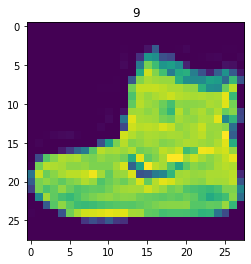

In [7]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

We can turn the image into grayscale using the cmap parameter of plt.imshow().

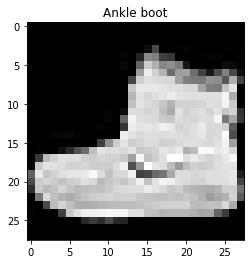

In [8]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

Beautiful, well as beautiful as a pixelated grayscale ankle boot can get.

Let's view a few more.

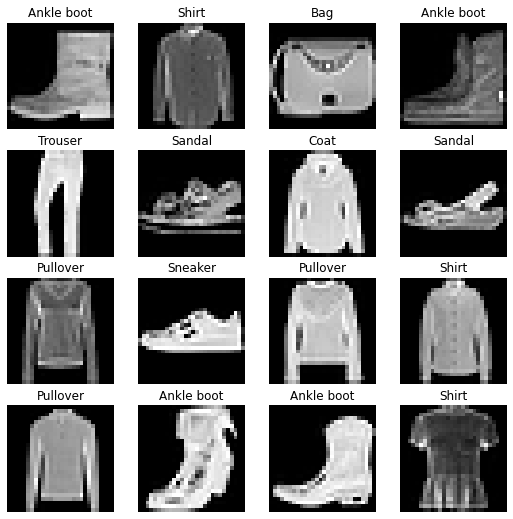

In [9]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 2. Prepare DataLoader

Let's create DataLoader's for our training and test sets.



In [10]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f9488faa290>, <torch.utils.data.dataloader.DataLoader object at 0x7f9488faa250>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [11]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

And we can see that the data remains unchanged by checking a single sample.

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


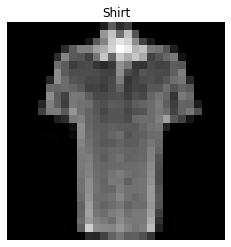

In [12]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

Understand the nn.Flatten() layer. 

In [13]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


Let's create our first model using nn.Flatten() as the first layer.

In [14]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [15]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### 3.1 Setup loss, optimizer and evaluation metrics

In [16]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [17]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 3.2 Creating a function to time our experiments

In [18]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Creating a training loop and training a model on batches of data

In [19]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 32.591 seconds


## 4. Make predictions and get Model 0 results

The function will use the model to make predictions on the data in the DataLoader and then we can evaluate those predictions using the loss function and accuracy function.

In [20]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

Looking good!

We can use this dictionary to compare the baseline model results to other models later on.

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [21]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [22]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [23]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer and evaluation metrics

In [24]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

### 6.2 Functionizing training and test loops

In [25]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Let's also time things to see how long our code takes to run on the GPU.

In [26]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cuda: 24.807 seconds


Excellent!

Our model trained but the training time took longer?

Let's evaluate our trained model_1 using our eval_model() function and see how it went.

In [29]:
torch.manual_seed(42)

# Note: This will error due to `eval_model()` not using device agnostic code 
model_1_results = eval_model(model=model_1, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn) 
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

How about we fix that by passing a target device parameter to our eval_model() function?

Then we'll try calculating the results again.

In [28]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [30]:
# Check baseline results
model_0_results


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 7. Model 2: Building a Convolutional Neural Network (CNN)

In [31]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1 Stepping through nn.Conv2d()

To test the layers out, let's create some toy data just like the data used on CNN Explainer.

In [32]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")


Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [33]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG 
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here 

# Pass the data through the convolutional layer
conv_layer(test_image).shape # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

torch.Size([10, 62, 62])

In [34]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [35]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [36]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [37]:
# Check out the conv_layer_2 internal parameters
print(conv_layer_2.state_dict())
print(f"weight dimensions:{conv_layer_2.state_dict()['weight'].shape}")
print(f"bias dimensions:{conv_layer_2.state_dict()['bias'].shape}")


OrderedDict([('weight', tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241,  0.0958, -0.0684, -0.0689, -0.0689],
          [ 0.1039,  0.0385,  0.1111, -0.0953, -0.1145]]],


        [[[-0.0903, -0.0777,  0.0468,  0.0413,  0.0959],
          [-0.0596, -0.0787,  0.0613, -0.0467,  0.0701],

In [39]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


### 7.2 Stepping through nn.MaxPool2d()

Now let's check out what happens when we move data through nn.MaxPool2d().

In [40]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


Notice the change in the shapes of what's happening in and out of a nn.MaxPool2d() layer.

The kernel_size of the nn.MaxPool2d() layer will effects the size of the output shape.

In our case, the shape halves from a 62x62 image to 31x31 image.

Let's see this work with a smaller tensor.

In [41]:
torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


Exercise: What do you think the nn.AvgPool2d() layer does? Try making a random tensor like we did above and passing it through. Check the input and output shapes as well as the input and output values.

In [43]:
torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
avg_pool_layer = nn.AvgPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

# Pass the random tensor through the max pool layer
avg_pool_tensor = avg_pool_layer(random_tensor)
print(f"\nAvg pool tensor:\n{avg_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Avg pool tensor shape: {avg_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Avg pool tensor:
tensor([[[[0.2326]]]]) <- this is the maximum value from random_tensor
Avg pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for model_2

In [45]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

### 7.4 Training and testing model_2 using our training and test functions

In [46]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59883 | Train accuracy: 78.26%
Test loss: 0.39621 | Test accuracy: 85.86%

Epoch: 1
---------
Train loss: 0.36214 | Train accuracy: 86.98%
Test loss: 0.35610 | Test accuracy: 86.56%

Epoch: 2
---------
Train loss: 0.32359 | Train accuracy: 88.25%
Test loss: 0.32345 | Test accuracy: 88.41%

Train time on cuda: 35.377 seconds


In [47]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3234495520591736,
 'model_acc': 88.40854632587859}

## 8. Compare model results and training time

In [48]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.323450,88.408546


Nice!

We can add the training time values too.

In [49]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,32.590577
1,FashionMNISTModelV1,0.685001,75.019968,24.806946
2,FashionMNISTModelV2,0.323450,88.408546,35.376532


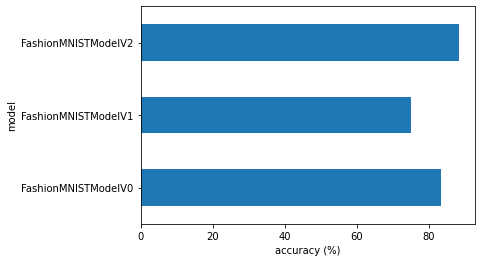

In [50]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. Make and evaluate random predictions with best model

In [51]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [52]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


And now we can use our make_predictions() function to predict on test_samples.

In [53]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.3184e-07, 1.6383e-07, 7.0263e-08, 3.2259e-07, 2.2857e-08, 9.9990e-01,
         3.8571e-07, 4.1985e-06, 2.8905e-05, 6.4944e-05],
        [4.8443e-02, 5.4339e-01, 1.2691e-03, 1.4903e-01, 4.2927e-02, 4.6822e-04,
         2.1202e-01, 9.3576e-04, 6.8723e-04, 8.3312e-04]])


Excellent!

And now we can go from prediction probabilities to prediction labels by taking the torch.argmax() of the output of the torch.softmax() activation function.

In [54]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

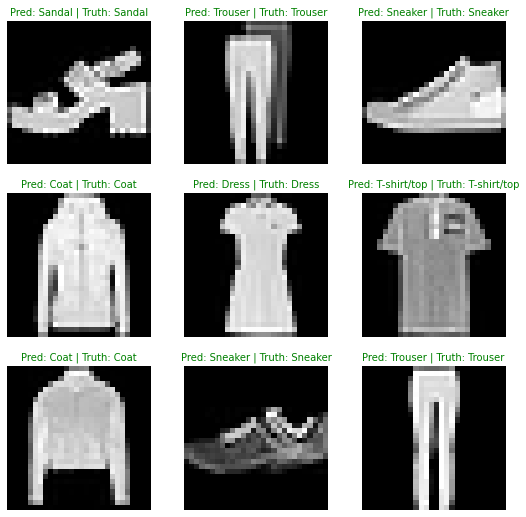

In [55]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

### 10. Making a confusion matrix for further prediction evaluation

In [56]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [57]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     |████████████████████████████████| 419 kB 27.8 MB/s 
     |████████████████████████████████| 1.3 MB 49.6 MB/s 
mlxtend version: 0.20.0



To plot the confusion matrix, we need to make sure we've got and mlxtend version of 0.19.0 or higher.

In [58]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.20.0


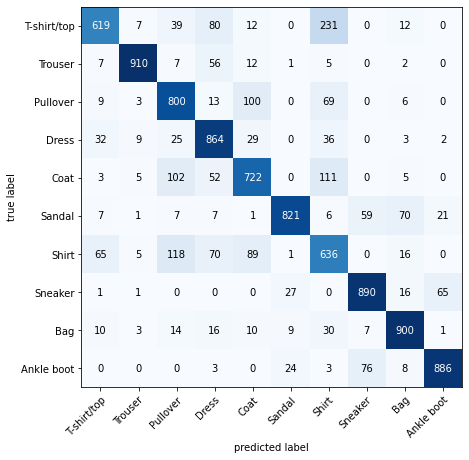

In [59]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 11. Save and load best performing model

In [60]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [61]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [62]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3234495520591736,
 'model_acc': 88.40854632587859}

If our model's results are close, the output of torch.isclose() should be true.

In [63]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)

## Exercises

In [64]:
# Check for GPU
!nvidia-smi

Fri Sep 16 08:37:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   1158MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [65]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.12.1+cu113


'cuda'

#### 1. What are 3 areas in industry where computer vision is currently being used?

1. Self-driving cars, such as Tesla using computer vision to percieve what's happening on the road. See Tesla AI day for more - https://youtu.be/j0z4FweCy4M

2. Healthcare imaging, such as using computer vision to help interpret X-rays. Google also uses computer vision for detecting polyps in the intenstines - https://ai.googleblog.com/2021/08/improved-detection-of-elusive-polyps.html

3. Security, computer vision can be used to detect whether someone is invading your home or not - https://store.google.com/au/product/nest_cam_battery?hl=en-GB

### 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting is like memorizing for a test but then you can't answer a question that's slightly different.

In other words, if a model is overfitting, it's learning the training data too well and these patterns don't generalize to unseen data.

#### 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.

See this article for some ideas: https://elitedatascience.com/overfitting-in-machine-learning

3 ways to prevent overfitting:

1. <b>Regularization techniques</b> - You could use dropout on your neural networks), dropout involves randomly removing neurons in different layers so that the remaining neurons hopefully learn more robust weights/patterns.

2. <b>Use a different model</b> - maybe the model you're using for a specific problem is too complicated, as in, it's learning the data too well because it has so many layers. You could remove some layers to simplify your model. Or you could pick a totally different model altogether, one that may be more suited to your particular problem. Or... you could also use transfer learning (taking the patterns from one model and applying them to your own problem).

3. <b>Reduce noise in data/cleanup dataset/introduce data augmentation techniques</b> - If the model is learning the data too well, it might be just memorizing the data, including the noise. One option would be to remove the noise/clean up the dataset or if this doesn't, you can introduce artificial noise through the use of data augmentation to artificially increase the diversity of your training dataset.

#### 4. Spend 20-minutes reading and clicking through the <a href=https://poloclub.github.io/cnn-explainer/>CNN Explainer website</a>.

Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

The CNN explainer website is a great insight into all of the nuts and bolts of a convolutional neural network.

#### 5. Load the torchvision.datasets.MNIST() train and test datasets.

In [66]:
import torchvision
from torchvision import datasets

from torchvision import transforms

In [67]:
# Get the MNIST train dataset 
train_data = datasets.MNIST(root=".",
                            train=True,
                            download=True,
                            transform=transforms.ToTensor()) # do we want to transform the data as we download it? 

# Get the MNIST test dataset
test_data = datasets.MNIST(root=".",
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [68]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [69]:
len(train_data), len(test_data)

(60000, 10000)

In [70]:
# Data is in tuple form (image, label)
img = train_data[0][0]
label = train_data[0][1]
print(f"Image:\n {img}") 
print(f"Label:\n {label}")

Image:
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [71]:
# Check out the shapes of our data
print(f"Image shape: {img.shape} -> [color_channels, height, width] (CHW)")
print(f"Label: {label} -> no shape, due to being integer")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width] (CHW)
Label: 5 -> no shape, due to being integer


In [72]:
# Get the class names from the dataset
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

#### 6. Visualize at least 5 different samples of the MNIST training dataset.

torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])


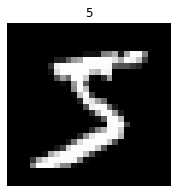

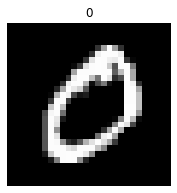

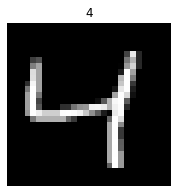

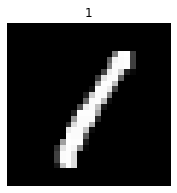

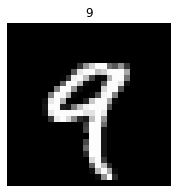

In [73]:
import matplotlib.pyplot as plt
for i in range(5):
  img = train_data[i][0]
  print(img.shape)
  img_squeeze = img.squeeze()
  print(img_squeeze.shape)
  label = train_data[i][1]
  plt.figure(figsize=(3, 3))
  plt.imshow(img_squeeze, cmap="gray")
  plt.title(label)
  plt.axis(False);

#### 7. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [74]:
# Create train dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [75]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f93d1a3cb90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f93d19ef890>)

In [76]:
for sample in next(iter(train_dataloader)):
  print(sample.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [77]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

#### 8. Recreate model_2 used in notebook 03 (the same model from the <a href=https://poloclub.github.io/cnn-explainer/>CNN Explainer website</a>, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [78]:
from torch import nn 
class MNIST_model(torch.nn.Module):
  """Model capable of predicting on MNIST dataset.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int): 
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, 
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1), 
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)                   
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7,
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv block 2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [79]:
device

'cuda'

In [80]:
model = MNIST_model(input_shape=1,
                    hidden_units=10,
                    output_shape=10).to(device)
model


MNIST_model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [81]:
# Check out the model state dict to find out what patterns our model wants to learn
model.state_dict()

OrderedDict([('conv_block_1.0.weight', tensor([[[[-0.1623,  0.1958,  0.2938],
                        [-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607]]],
              
              
                      [[[-0.0471,  0.2570,  0.0493],
                        [-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211]]],
              
              
                      [[[-0.2631, -0.1537, -0.0941],
                        [-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573]]],
              
              
                      [[[ 0.0555, -0.1082,  0.2060],
                        [ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904]]],
              
              
                      [[[ 0.1403,  0.2976,  0.1927],
                        [-0.1457,  0.1924,  0.0596],
                        [ 0.1693, -0.2032, -0.3300]]],
              
              
                    

In [82]:
# Try a dummy forward pass to see what shapes our data is
dummy_x = torch.rand(size=(1, 28, 28)).unsqueeze(dim=0).to(device)
# dummy_x.shape
model(dummy_x)

tensor([[ 0.0135, -0.0618,  0.0858, -0.0315,  0.0105,  0.0255,  0.0006,  0.0437,
         -0.0697, -0.0114]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [83]:
dummy_x_2 = torch.rand(size=([1, 10, 7, 7]))
dummy_x_2.shape

torch.Size([1, 10, 7, 7])

In [84]:
flatten_layer = nn.Flatten()
flatten_layer(dummy_x_2).shape

torch.Size([1, 490])

#### 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [86]:
%%time
from tqdm.auto import tqdm 

# Train on CPU
model_cpu = MNIST_model(input_shape=1,
                        hidden_units=10,
                        output_shape=10).to("cpu") 

# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cpu.parameters(), lr=0.1)

### Training loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_cpu.train()

    # Put data on CPU
    X, y = X.to("cpu"), y.to("cpu")

    # Forward pass
    y_pred = model_cpu(X)

    # Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Step the optimizer
    optimizer.step()
  
  # Adjust train loss for number of batches
  train_loss /= len(train_dataloader)

  ### Testing loop
  test_loss_total = 0

  # Put model in eval mode 
  model_cpu.eval()

  # Turn on inference mode
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      # Make sure test data on CPU
      X_test, y_test = X_test.to("cpu"), y_test.to("cpu")
      test_pred = model_cpu(X_test)
      test_loss = loss_fn(test_pred, y_test)

      test_loss_total += test_loss
    
    test_loss_total /= len(test_dataloader)
  
  # Print out what's happening
  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.296 | Test loss: 0.089
Epoch: 1 | Loss: 0.079 | Test loss: 0.053
Epoch: 2 | Loss: 0.062 | Test loss: 0.074
Epoch: 3 | Loss: 0.053 | Test loss: 0.052
Epoch: 4 | Loss: 0.046 | Test loss: 0.043
CPU times: user 3min 32s, sys: 3.3 s, total: 3min 36s
Wall time: 3min 41s


In [87]:
%%time
from tqdm.auto import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"

# Train on GPU
model_gpu = MNIST_model(input_shape=1,
                        hidden_units=10,
                        output_shape=10).to(device)

# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.1)

# Training loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss = 0
  model_gpu.train()
  for batch, (X, y) in enumerate(train_dataloader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model_gpu(X)

    # Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Step the optimizer
    optimizer.step()
  
  # Adjust train loss to number of batches
  train_loss /= len(train_dataloader)

  ### Testing loop
  test_loss_total = 0
  # Put model in eval mode and turn on inference mode
  model_gpu.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      # Make sure test data on target device
      X_test, y_test = X_test.to(device), y_test.to(device)
      
      test_pred = model_gpu(X_test)
      test_loss = loss_fn(test_pred, y_test)

      test_loss_total += test_loss

    # Adjust test loss total for number of batches
    test_loss_total /= len(test_dataloader)
  
  # Print out what's happening
  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.314 | Test loss: 0.116
Epoch: 1 | Loss: 0.077 | Test loss: 0.056
Epoch: 2 | Loss: 0.060 | Test loss: 0.049
Epoch: 3 | Loss: 0.051 | Test loss: 0.044
Epoch: 4 | Loss: 0.045 | Test loss: 0.045
CPU times: user 55.5 s, sys: 548 ms, total: 56 s
Wall time: 58.5 s


#### 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

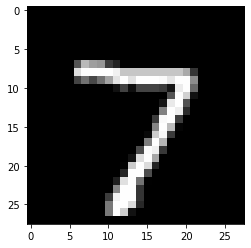

In [88]:
# Make predictions with the trained model
plt.imshow(test_data[0][0].squeeze(), cmap="gray")

In [89]:
# Logits -> Prediction probabilities -> Prediction labels
model_pred_logits = model_gpu(test_data[0][0].unsqueeze(dim=0).to(device)) # make sure image is right shape + on right device
model_pred_probs = torch.softmax(model_pred_logits, dim=1)
model_pred_label = torch.argmax(model_pred_probs, dim=1)
model_pred_label

tensor([7], device='cuda:0')

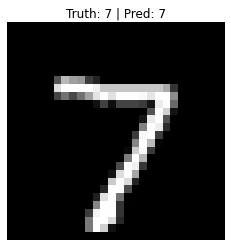

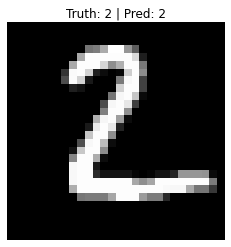

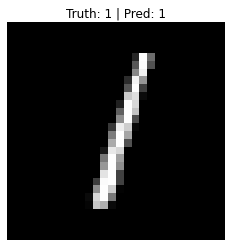

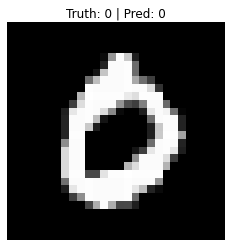

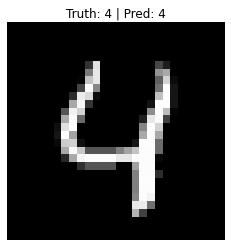

In [90]:
num_to_plot = 5 
for i in range(num_to_plot):
  # Get image and labels from the test data
  img = test_data[i][0]
  label = test_data[i][1]

  # Make prediction on image
  model_pred_logits = model_gpu(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  # Plot the image and prediction
  plt.figure()
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Truth: {label} | Pred: {model_pred_label.cpu().item()}") 
  plt.axis(False);

#### 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [91]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.20.0


In [92]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.20.0


In [93]:
# Make predictions across all test data
from tqdm.auto import tqdm
model_gpu.eval()
y_preds = []
with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    # Make sure data on right device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred_logits = model_gpu(X)
    # Logits -> Pred probs -> Pred label
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    # Append the labels to the preds list
    y_preds.append(y_pred_labels)
  y_preds=torch.cat(y_preds).cpu()
len(y_preds)

0it [00:00, ?it/s]

10000

In [94]:
test_data.targets[:10], y_preds[:10]

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

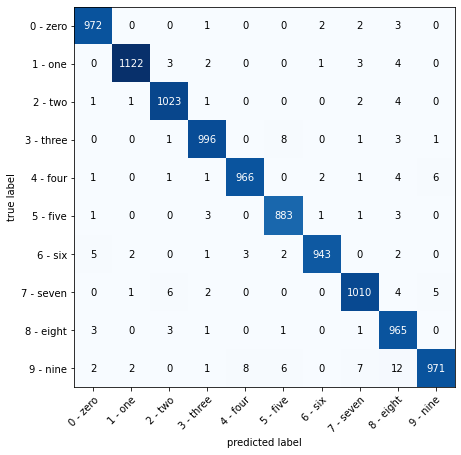

In [95]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix 
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

#### 12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [96]:
random_tensor = torch.rand([1, 3, 64, 64])
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [97]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=64,
                       kernel_size=3,
                       stride=2,
                       padding=1)

print(f"Random tensor original shape: {random_tensor.shape}")
random_tensor_through_conv_layer = conv_layer(random_tensor)
print(f"Random tensor through conv layer shape: {random_tensor_through_conv_layer.shape}")

Random tensor original shape: torch.Size([1, 3, 64, 64])
Random tensor through conv layer shape: torch.Size([1, 64, 32, 32])


#### 13. Use a model similar to the trained model_2 from notebook 03 to make predictions on the test torchvision.datasets.FashionMNIST dataset.

In [98]:
# Download FashionMNIST train & test
from torchvision import datasets
from torchvision import transforms

fashion_mnist_train = datasets.FashionMNIST(root=".",
                                            download=True,
                                            train=True,
                                            transform=transforms.ToTensor())

fashion_mnist_test = datasets.FashionMNIST(root=".",
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

len(fashion_mnist_train), len(fashion_mnist_test)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



(60000, 10000)

In [99]:
# Get the class names of the Fashion MNIST dataset
fashion_mnist_class_names = fashion_mnist_train.classes
fashion_mnist_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [100]:
# Turn FashionMNIST datasets into dataloaders
from torch.utils.data import DataLoader

fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train,
                                            batch_size=32,
                                            shuffle=True)

fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test,
                                           batch_size=32,
                                           shuffle=False)

len(fashion_mnist_train_dataloader), len(fashion_mnist_test_dataloader)

(1875, 313)

In [101]:
# model_2 is the same architecture as MNIST_model
model_2 = MNIST_model(input_shape=1,
                      hidden_units=10,
                      output_shape=10).to(device)
model_2

MNIST_model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [102]:
# Setup loss and optimizer
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [103]:
# Setup metrics
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(num_classes=len(fashion_mnist_class_names)).to(device) 

# Setup training/testing loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss, test_loss_total = 0, 0
  train_acc, test_acc = 0, 0 

  ### Training
  model_2.train()
  for batch, (X_train, y_train) in enumerate(fashion_mnist_train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Forward pass and loss
    y_pred = model_2(X_train)
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    train_acc += acc_fn(y_pred, y_train)

    # Backprop and gradient descent
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()

  # Adjust the loss/acc (find the loss/acc per epoch)
  train_loss /= len(fashion_mnist_train_dataloader)
  train_acc /= len(fashion_mnist_train_dataloader)

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(fashion_mnist_test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass and loss
      y_pred_test = model_2(X_test)
      test_loss = loss_fn(y_pred_test, y_test)
      test_loss_total += test_loss

      test_acc += acc_fn(y_pred_test, y_test)
  
    # Adjust the loss/acc (find the loss/acc per epoch)
    test_loss /= len(fashion_mnist_test_dataloader)
    test_acc /= len(fashion_mnist_test_dataloader)
    
  # Print out what's happening
  print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.001 | Train acc: 0.64 | Test loss: 184.400 | Test acc: 0.77
Epoch: 1 | Train loss: 0.501 | Train acc: 0.82 | Test loss: 152.874 | Test acc: 0.82
Epoch: 2 | Train loss: 0.432 | Train acc: 0.84 | Test loss: 132.812 | Test acc: 0.85
Epoch: 3 | Train loss: 0.399 | Train acc: 0.86 | Test loss: 126.135 | Test acc: 0.86
Epoch: 4 | Train loss: 0.376 | Train acc: 0.86 | Test loss: 122.008 | Test acc: 0.86


In [104]:
# Make predictions with trained model_2
test_preds = []
model_2.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_mnist_test_dataloader):
    y_logits = model_2(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # matplotlib likes CPU
test_preds[:10], len(test_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [105]:
# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_mnist_test.targets)[0]
len(wrong_pred_indexes)

1403

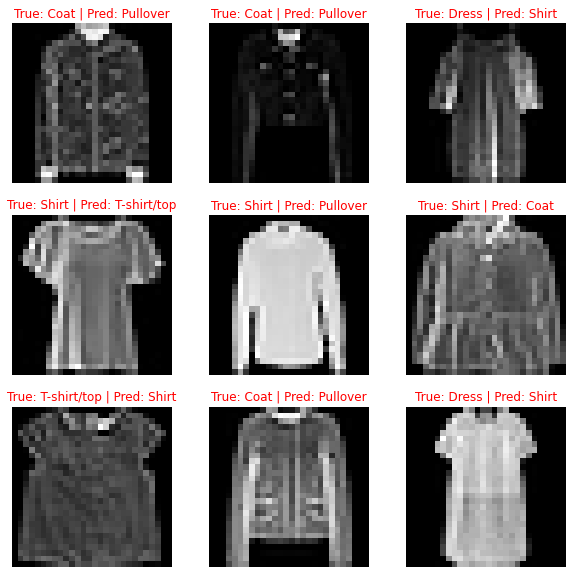

In [106]:
# Select random 9 wrong predictions and plot them
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = fashion_mnist_class_names[fashion_mnist_test[idx][1]]
  pred_label = fashion_mnist_class_names[test_preds[idx]]

  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_mnist_test[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False);

From the look of some of these predictions, the model is getting about as confused as I would...

For example it predicts "Sneaker" instead of "Sandal" when it could have easily been a "Sneaker".

The same goes for the confusion between the classes of "T-shirt/top" and "Shirt", many of the examples here look similar.